In [235]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from textblob import TextBlob
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shashu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/shashu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [236]:
df = pd.read_csv("cyberbullying_tweets.csv")

In [237]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [238]:
df.duplicated().sum()
df.drop_duplicates(keep='first', inplace=True)

In [239]:
def clean_tweet_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtag symbol
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()]) # Lemmatization
    return text

df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_tweet_text)
df[['tweet_text', 'cleaned_tweet_text']].head()
df.drop("tweet_text", axis=1, inplace=True)

In [240]:
#df = df.loc[df['cyberbullying_type'] != 'other_cyberbullying']
df["cleaned_tweet_text"].duplicated().sum()
df.drop_duplicates("cleaned_tweet_text", inplace=True)

In [241]:
df[['cyberbullying_type']].value_counts()

cyberbullying_type 
religion               7953
age                    7887
ethnicity              7774
not_cyberbullying      7664
gender                 7625
other_cyberbullying    5808
Name: count, dtype: int64

In [242]:
X = df['cleaned_tweet_text']
y = df['cyberbullying_type']

In [243]:
knn = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=100)),
    ('clf', KNeighborsClassifier(n_neighbors=9, weights='uniform', metric='euclidean'))
])

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [245]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

                age       0.95      0.92      0.93      1561
          ethnicity       0.97      0.95      0.96      1590
             gender       0.84      0.78      0.81      1535
  not_cyberbullying       0.52      0.65      0.58      1604
other_cyberbullying       0.44      0.42      0.43      1132
           religion       0.95      0.87      0.91      1521

           accuracy                           0.78      8943
          macro avg       0.78      0.76      0.77      8943
       weighted avg       0.79      0.78      0.78      8943



In [199]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import TruncatedSVD
# import matplotlib.pyplot as plt
# import numpy as np

# tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# # Fit and transform the training data
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# svd = TruncatedSVD(n_components=5000)
# svd.fit(X_train_tfidf)

# # Plotting the cumulative explained variance
# plt.figure(figsize=(10, 7))
# plt.plot(np.cumsum(svd.explained_variance_ratio_))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs Number of Components')
# plt.grid(True)
# plt.show()


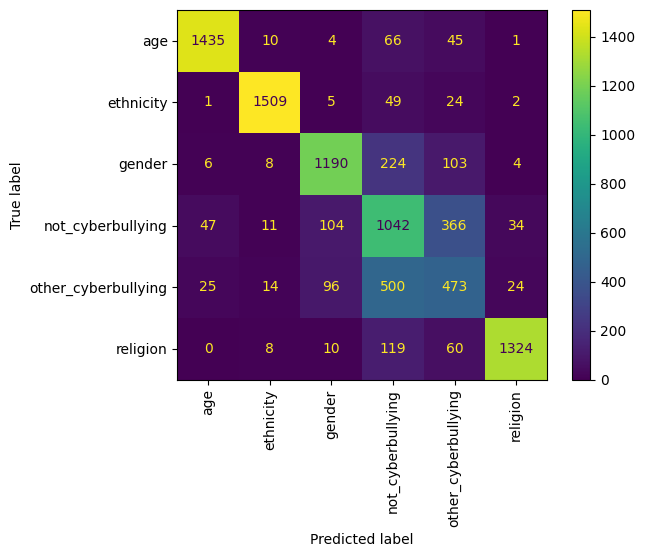

In [246]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)

# Display the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=knn.classes_)
cmd.plot(xticks_rotation='vertical')
plt.show()